In [1]:
%cd /workspaces/course-master-of-AI-/dataset

/workspaces/course-master-of-AI-/dataset


/root/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
# !pip uninstall torch torchvision torchaudio --yes
# !pip install torch==2.3.0 torchvision==0.18.0 torchaudio==2.3.0 --index-url https://download.pytorch.org/whl/cu121

In [3]:
import os
import pandas as pd
import numpy as np

In [4]:
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights


In [5]:
!pip freeze | grep torch 

torch==2.3.0+cu121
torchaudio==2.3.0+cu121
torchvision==0.18.0+cu121


In [6]:
# torch.zeros(1).cuda()

In [7]:
torch.cuda.is_available()

True

In [8]:
dataset_path = '/workspaces/course-master-of-AI-/dataset/faster_RCNN'
yaml_file_path = os.path.join(dataset_path, 'data.yaml')
csv_file_path = os.path.join(dataset_path, 'dataset.csv')

In [9]:
import yaml


def get_label(yaml_file_path):
    # Read the YAML file
    with open(yaml_file_path, 'r') as file:
        yaml_content = yaml.safe_load(file)

    # Extract the 'names' and convert it to an array
    names_dict = yaml_content.get('names', {})
    names_array = [names_dict[key] for key in sorted(names_dict.keys(), key=int)]

    return names_array


In [10]:
df = pd.read_csv(csv_file_path)

df

,Unnamed: 0,image_name,label_index,x1,y1,x2,y2
0,0,contamination_016,2,255,260,646,661
1,1,broken_small_001,1,238,580,291,640
2,2,broken_large_007,0,119,234,773,798
3,3,broken_small_015,1,520,213,701,399
4,4,broken_small_011,1,656,647,681,670
...,...,...,...,...,...,...,...
58,58,broken_small_010,1,459,163,739,546
59,59,broken_small_007,1,646,302,755,563
60,60,contamination_020,2,251,273,643,663
61,61,broken_large_014,0,151,354,458,732


In [11]:
unique_imgs = df.image_name.unique()
# len(df)
# unique_imgs.size
unique_imgs

array(['contamination_016', 'broken_small_001', 'broken_large_007',
       'broken_small_015', 'broken_small_011', 'broken_small_005',
       'broken_large_009', 'broken_large_006', 'broken_large_012',
       'contamination_001', 'broken_large_008', 'contamination_013',
       'contamination_008', 'broken_small_013', 'contamination_018',
       'broken_large_001', 'broken_large_004', 'broken_small_014',
       'broken_large_019', 'contamination_015', 'contamination_006',
       'contamination_019', 'contamination_009', 'broken_small_018',
       'contamination_000', 'broken_small_021', 'broken_large_016',
       'broken_large_018', 'broken_large_011', 'contamination_012',
       'contamination_004', 'broken_large_002', 'contamination_005',
       'contamination_002', 'broken_large_015', 'broken_large_003',
       'broken_small_017', 'broken_large_013', 'broken_large_017',
       'contamination_014', 'contamination_007', 'broken_small_006',
       'broken_small_012', 'broken_large_010',

In [12]:
class MVTecADDataset(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indices):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indices = indices
   

    def __len__(self):
        return len(self.unique_imgs)

    def __getitem__(self, idx):
        # print(self.indices)
        # print(idx)
        # id = self.indices[idx]
        # print(id)
        image_name = self.unique_imgs[idx]
        # print(f'image_name: "{image_name}"')
        sel = self.df[self.df.image_name == image_name]
        boxes = sel.values[:, 3:]
        labels = sel.values[:, 2]
#         print(boxes)
        boxes = boxes.astype('float')
        labels = labels.astype('int64')
        img = Image.open(os.path.join(dataset_path, f'images/{image_name}.png')) # .convert('RGP')
        
        target = {}
        target['boxes'] = torch.tensor(boxes)
        target['label'] = torch.tensor(labels)
        return T.ToTensor()(img), target


In [13]:
train_inds, val_inds = train_test_split(range(unique_imgs.shape[0]), test_size = 0.5)

In [14]:
# len(train_inds)
# len(val_inds)


In [15]:
test = MVTecADDataset(df, unique_imgs, train_inds)
test[1]

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 {'boxes': tensor([[238., 580., 291., 640.]], dtype=torch.float64),
  'label': tensor([1])})

In [16]:
def custom_collate(x): return x


train_dl = torch.utils.data.DataLoader(MVTecADDataset(df, unique_imgs, train_inds),
                                       batch_size=16,
                                       shuffle=True,
                                       collate_fn=custom_collate,
                                       pin_memory=True if torch.cuda.is_available() else False
                                       )
val_dl = torch.utils.data.DataLoader(MVTecADDataset(df, unique_imgs, val_inds),
                                     batch_size=8,
                                     shuffle=True,
                                     collate_fn=custom_collate,
                                     pin_memory=True if torch.cuda.is_available() else False
                                     )

In [17]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)

labels = get_label(yaml_file_path)
num_classes = len(labels)

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [18]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [19]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9, weight_decay = 0.0005)
num_epochs = 10

In [20]:
model.to(device)

for epoch in range(num_epochs):
    epoch_loss = 0
    for data in train_dl:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ['boxes'] = d[1]['boxes'].to(device)
            targ['labels'] = d[1]['label'].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss = loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'epoch_loss: {epoch_loss}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


epoch_loss: 0.35282324242159907
epoch_loss: 0.2090672835905194
epoch_loss: 0.3103916432239945
epoch_loss: 0.2775147013575
epoch_loss: 0.24249808085074662
epoch_loss: 0.21049692693676286
epoch_loss: 0.17157201422004378
epoch_loss: 0.2057364881971557
epoch_loss: 0.20497979390691246
epoch_loss: 0.17518669687862198


In [21]:
model.eval()

data = iter(val_dl).__next__()

In [22]:
img = data[0][0]

boxes = data[0][1]['boxes']
labels = data[0][1]['label']

In [23]:
output = model([img.to(device)])

In [24]:
out_bbox = output[0]['boxes']
out_scores = output[0]['scores']

In [25]:
keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)

In [26]:
out_bbox.shape, keep.shape

(torch.Size([61, 4]), torch.Size([21]))

In [27]:
im = (img.permute(1,2,0).cpu().detach().numpy()*255).astype('uint8')
im

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

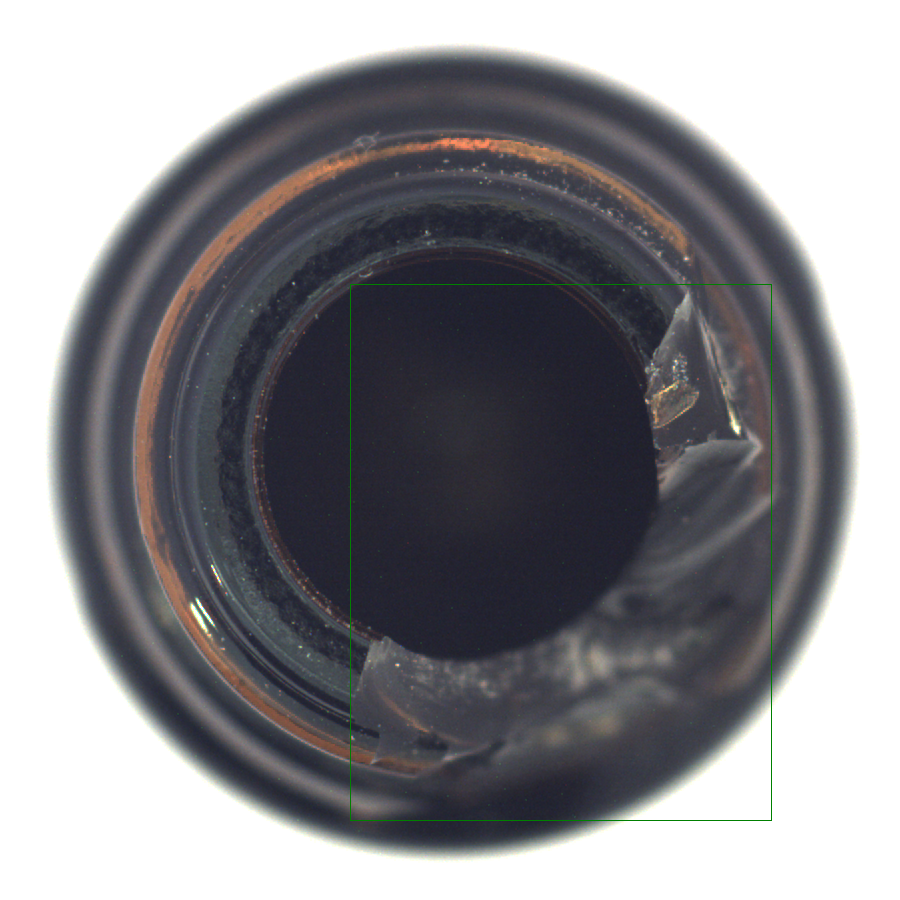

In [34]:
vsample = Image.fromarray(im)

draw = ImageDraw.Draw(vsample)

for box in boxes:
    draw.rectangle(list(box), fill = None, outline = 'green')

# for box in keep:
#     draw.rectangle(list(box), fill = None, outline = 'red')

vsample